In [2]:
import numpy as np
import tensorflow as tf
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

from create_env import create_env
from observation_2018 import process_observation
from observation_2018 import processed_dims
from reward_mod import print_target_changes
from reward_mod import get_target_speed_heading
from reward_mod import bind_alt_reset
from reward_mod import bind_alt_reward

from ddpg_multi_agent import Agent


In [3]:
def set_all_seeds(seed):
    tf.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def draw_path(env):
    xv = env.targets[:,0]
    zv = env.targets[:,2]
    xp = np.cumsum(xv)
    zp = np.cumsum(zv)
    plt.figure(figsize=(16, 8))
    plt.grid(True)
    plt.axis([0, 2000, -500, 500])      # make sure it's in scale
    plt.plot(xp,zp*-1.0)                # z axis is other way in 3d view

def draw_speed_heading(env):
    speed, heading = get_target_speed_heading(env)
    plt.figure(figsize=(16, 5))
    plt.grid(True)
    plt.plot(speed)
    plt.plot(heading)

def blend_color(t, c1, c2):
    t = np.clip(t, 0, 1)
    c1 = colors.rgb_to_hsv(c1)
    c2 = colors.rgb_to_hsv(c2)
    c = ((c1 * t) + (c2 * (1-t)))
    c = np.clip(c, 0.0, 1.0)
    return colors.hsv_to_rgb(c)
    
def draw_rewards(rewards, xv, zv):
    clear_output(True)
    plt.figure(figsize=(16, 8*2))
    # rewards
    plt.subplot(2, 1, 1)   # nrows, ncols, index
    plt.grid(True)
    plt.title('reward')
    plt.plot(rewards)
    # path
    xp = np.cumsum(xv)
    zp = np.cumsum(zv)
    plt.subplot(2, 1, 2)
    plt.grid(True)
    plt.axis([0, 2000, -500, 500])
    plt.plot(xp,zp*-1.0)                 # z axis is other way in 3d view    
    # display
    plt.tight_layout()
    plt.show()
    
# this doesn't reset env, need to do it before    
def test_debug(agent, env_test, plain_obs, visualize=True):
    step_nr = 0
    total_reward = 0
    
    if visualize:
        clear_output(True)
    rewards = []
    pv_x = []
    pv_z = []
    
    while True:
        # get observation
        observation = np.array( process_observation(plain_obs) )
        
        # get action
        action = agent.get_max_action(observation)

        # get pelvis vel
        state_desc = env_test.get_state_desc()
        pv_x.append(state_desc["body_vel"]["pelvis"][0])
        pv_z.append(state_desc["body_vel"]["pelvis"][2])

        # do step
        action_out = [float(action[i]) for i in range(len(action))]
        plain_obs, reward, done, _info = env_test.step(action_out, project=False)

        # update stats
        step_nr += 1
        total_reward += reward
        rewards.append(reward)

        if visualize:
            draw_rewards(rewards, pv_x, pv_z)
        
        if done:
            break
            
    if visualize:
        print('Done after', step_nr, 'got_reward', total_reward)
    else:
        return rewards, pv_x, pv_z, total_reward, step_nr

# run many test runs and gather statistics
def run_tests(agent, env_test, test_nr):
    seed = 1
    test_stats = []
    total_reward_sum = 0
    low_reward = 10000
    high_reward = 0
    
    for _ in range(test_nr):
        set_all_seeds(seed)
        plain_obs = env_test.reset(project=False)
        rewards, pv_x, pv_z, total_reward, step_nr = test_debug(agent, env_test, plain_obs, visualize=False)
        test_stats.append([rewards, pv_x, pv_z, total_reward, step_nr])
        total_reward_sum += total_reward 
        if total_reward > high_reward:
            high_reward = total_reward
        if total_reward < low_reward:
            low_reward = total_reward
        print(seed, ": Test done with reward:", total_reward, "after", step_nr, "steps")
        seed += 1

    total_reward_sum /= test_nr
    print("Average reward:", total_reward_sum, "Lowest reward:", low_reward, "Highest reward:", high_reward)

    # todo: print all paths in one graph with color coding for total score
    return test_stats
    

In [4]:
# create visual test env
env = create_env(train=False, render=True)
#bind_alt_reset(env)
#bind_alt_reward(env)


In [5]:
# create agent
model_path = './model_prosthetics_v2'
agent = Agent(processed_dims, env.action_space, discount_factor=.96, model_path=model_path)

observation shape: (321,)
action shape:  (19,)


In [8]:
model_version = 'model-20000'
agent.load_weights(model_version)

Loading Model...
INFO:tensorflow:Restoring parameters from ./model_prosthetics_v2/model-20000
No model checkpoint available!


False

In [65]:
set_all_seeds(1234)

In [66]:
plain_obs = env.reset(project=False)

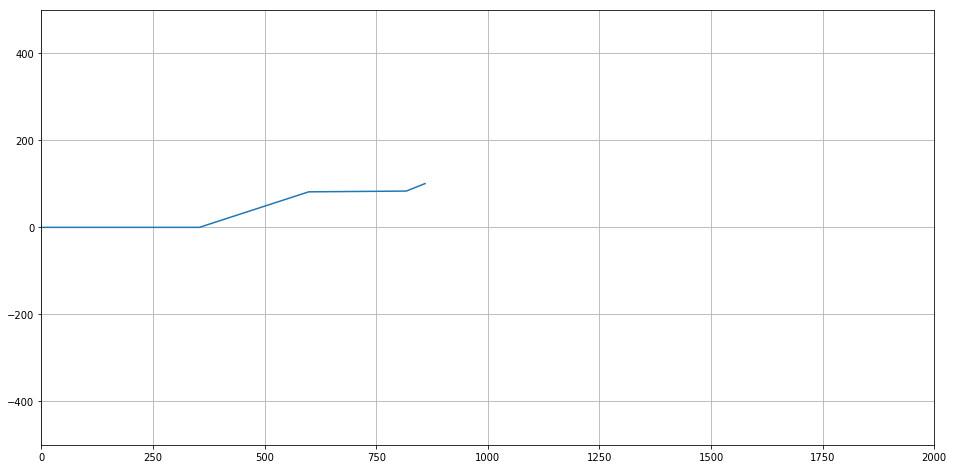

In [67]:
draw_path(env)

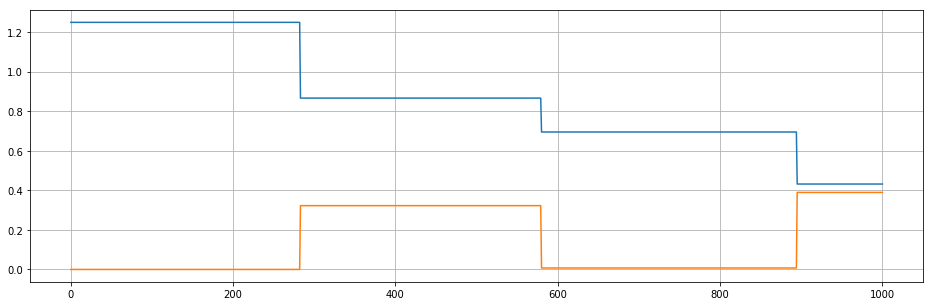

In [68]:
draw_speed_heading(env)

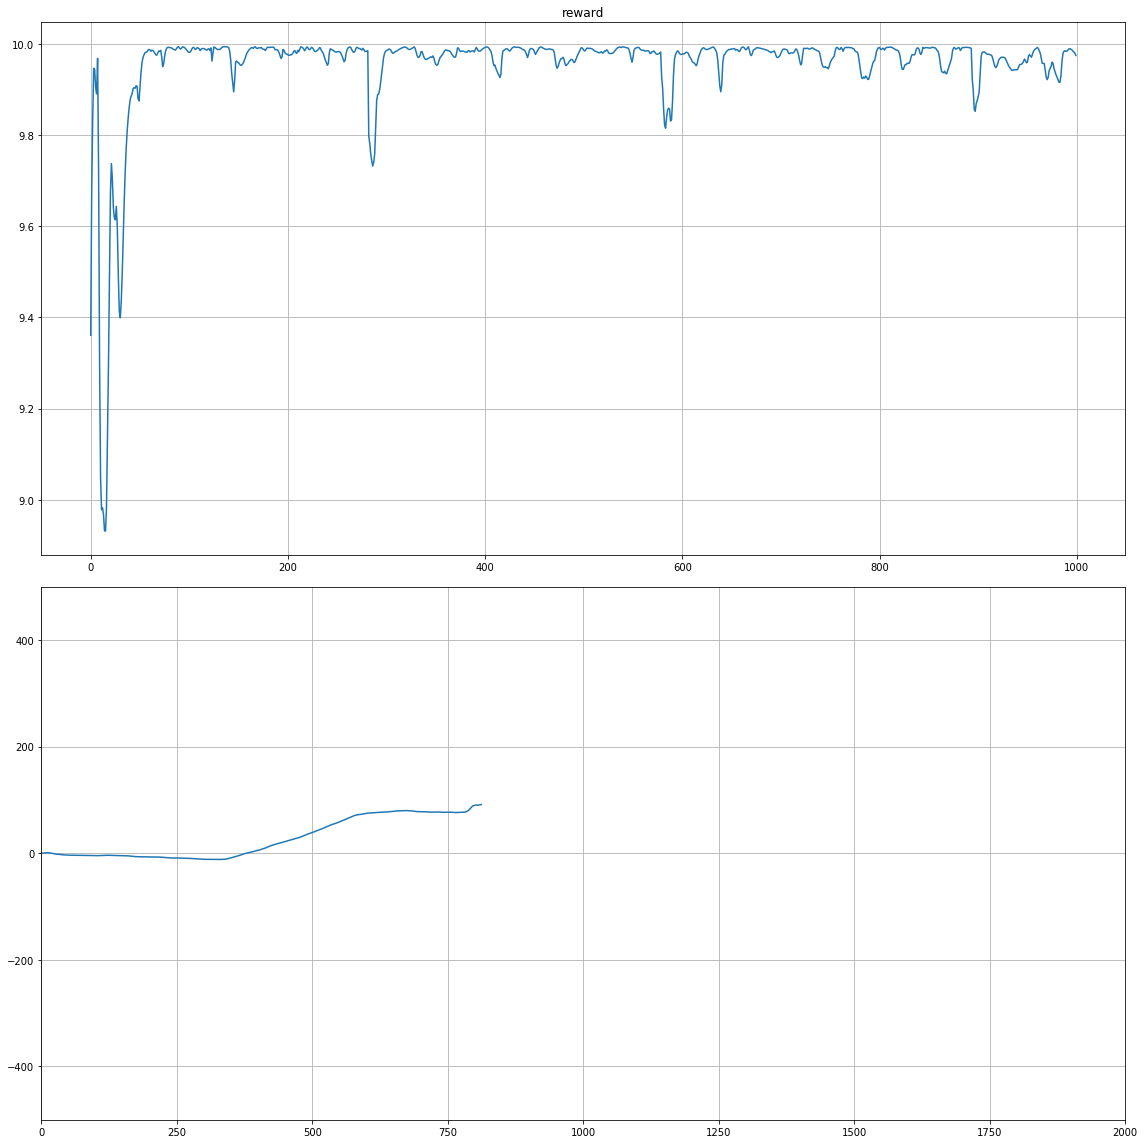

Done after 1000 got_reward 9954.715884827861


In [69]:
test_debug(agent, env, plain_obs)

In [6]:
# create test env
env_test = create_env(train=False, render=False)

In [ ]:
test_stats = run_tests(agent, env_test, 30)

1 : Test done with reward: 9866.458793354728 after 1000 steps
2 : Test done with reward: 9888.997606094868 after 1000 steps
3 : Test done with reward: 9920.816783461934 after 1000 steps
4 : Test done with reward: 9898.970308674781 after 1000 steps
5 : Test done with reward: 9913.915309915044 after 1000 steps
6 : Test done with reward: 9920.512872307396 after 1000 steps
7 : Test done with reward: 9899.184502521688 after 1000 steps
8 : Test done with reward: 9909.413844894405 after 1000 steps
9 : Test done with reward: 9904.078541778277 after 1000 steps
10 : Test done with reward: 9892.964224185735 after 1000 steps
11 : Test done with reward: 9878.30643525546 after 1000 steps
12 : Test done with reward: 6846.603048581547 after 692 steps
13 : Test done with reward: 9925.06177882473 after 1000 steps
14 : Test done with reward: 9920.269089219135 after 1000 steps


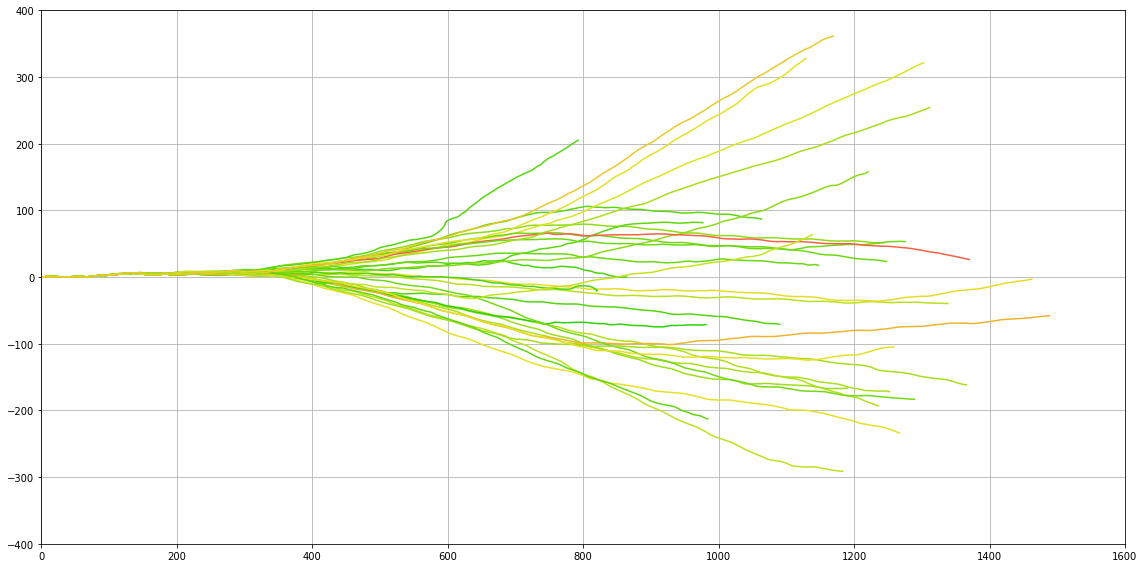

In [149]:
def draw_test_rewards(test_stats):
    #clear_output(True)
    plt.figure(figsize=(16, 8))
    
    # test_stats = [[rewards, pv_x, pv_z, total_reward, step_nr] ... ]
    plt.grid(True)
    scale = 0.8
    plt.axis([0, 2000*scale, -500*scale, 500*scale])
    for i, stats in enumerate(test_stats):        
        xv = stats[1]
        zv = stats[2]
        xp = np.cumsum(xv)
        zp = np.cumsum(zv)
        reward = stats[3]
        
        c1 = colors.rgb_to_hsv((0.0, 0.8, 0.0))
        c2 = colors.rgb_to_hsv((1.0, 0.3, 0.3))
        t = np.clip((reward-9800) / 150, 0, 1)
        c = ((c1 * t) + (c2 * (1-t)))
        c = np.clip(c, 0.0, 1.0)
        c = colors.hsv_to_rgb(c)
        plt.plot(xp, zp*-1.0, color=c)
    
    # display    
    plt.tight_layout()
    plt.show()


draw_test_rewards(test_stats)
